# Data augmentation

This sheet is for you to use to understand different code involved in data augmentation. Throughout the code there are TODO segements. This will give you an isntruction of what to do.

In [ ]:
!pip install opencv-python
!pip install kagglehub

In [ ]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
url = 'https://pbs.twimg.com/media/GvWCRsvWcAA28YW?format=jpg&name=large' #feel free to replace 

## Images

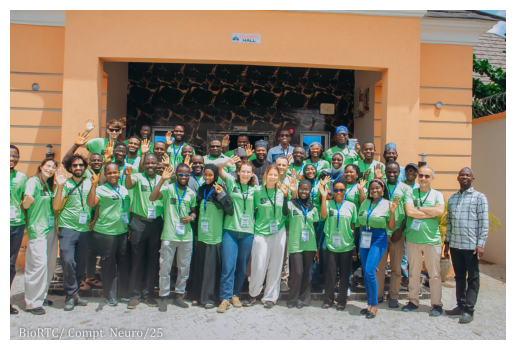

In [6]:
#load in an image
resp = requests.get(url)
img_arr = np.asarray(bytearray(resp.content), dtype=np.uint8)
image = cv2.imdecode(img_arr, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis("off")
plt.show()

### adding noise

We can add or subtrack a matrix of noise from the image. Have a go playing with the parameters

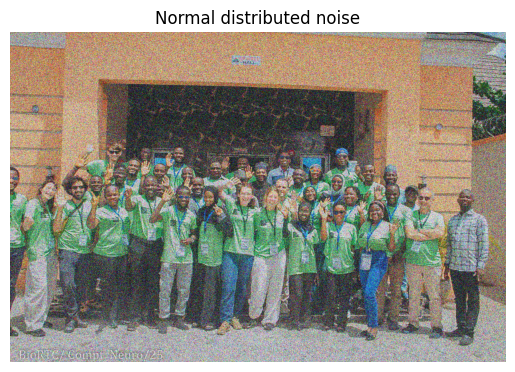

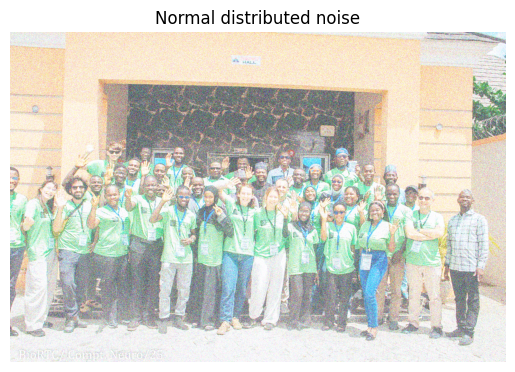

In [32]:
mean=0
std=100 #TODO play around with std
#generate normal distributed noise
noise = np.random.normal(mean,std,image.shape)

noise_image = image + noise

#make sure we keep in 0-255 value for pixels
noise_image[noise_image>255]=255
noise_image[noise_image<0]=0
noise_image=noise_image.astype(np.uint8)
plt.imshow(noise_image)
plt.title("Normal distributed noise")
plt.axis("off")
plt.show()

#complety random noise
noise = np.random.random(image.shape)*200 #TODO play around with scale

noise_image = image + noise

#make sure we keep in 0-255 value for pixels
noise_image[noise_image>255]=255
noise_image[noise_image<0]=0
noise_image=noise_image.astype(np.uint8)
plt.imshow(noise_image)
plt.title("Normal distributed noise")
plt.axis("off")
plt.show()


### CV2 filters
You can also filter the images for specific shapes or patterns. For example, if you care about the edges of an image you may use something like the canny edge detector or sobel filter. If you are interested in specific colours you may binary threshold certain values out.

Think about if you were making a model using this image. What is useful for the task. Lets say we want to count how many people there are, we could remove colour to reduce the number of parameters... but canny edge and sobel might be removing too much information to be useful. 

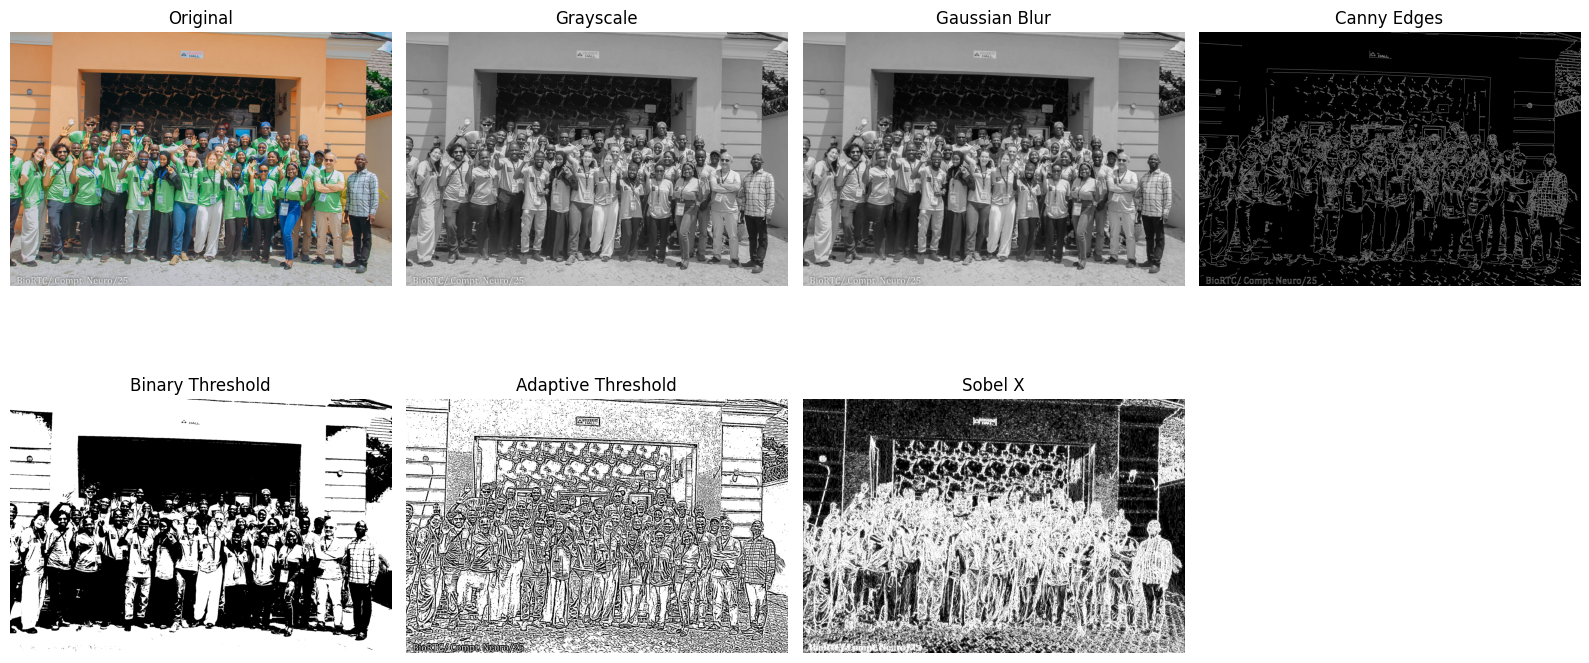

In [ ]:
#convert BGR to RGB and grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#preprocessing

blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(gray, 100, 200)
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                 cv2.THRESH_BINARY, 11, 2)
sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5) 
sobel = cv2.convertScaleAbs(sobel)

#plotting
titles = ['Original', 'Grayscale', 'Gaussian Blur', 'Canny Edges', 
          'Binary Threshold', 'Adaptive Threshold', 'Sobel X']
images = [image, gray, blur, edges, thresh, adaptive, sobel]

plt.figure(figsize=(16, 8))
for i in range(len(images)):
    plt.subplot(2, 4, i + 1)
    if len(images[i].shape) == 2:
        plt.imshow(images[i], cmap='gray')
    else:
        plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

### rotating 

We can rotate images to make sure the model is learning shapes rather than specific orientations. If the model was counting how man people there are, then it should be fine

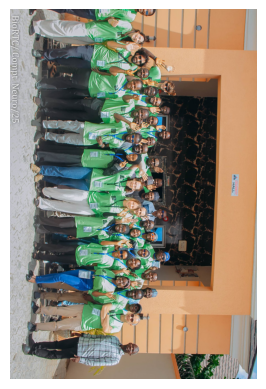

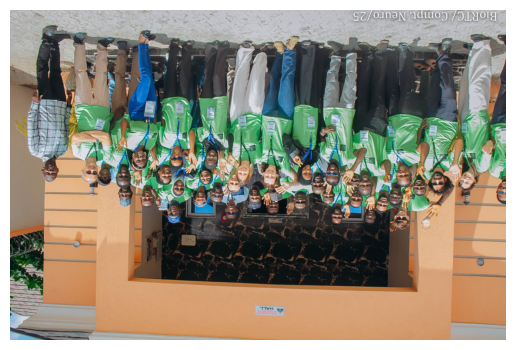

In [39]:
rotated1 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
rotated2 = cv2.rotate(rotated1, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(rotated1)
plt.axis("off")
plt.show()


plt.imshow(rotated2)
plt.axis("off")
plt.show()

### cropping

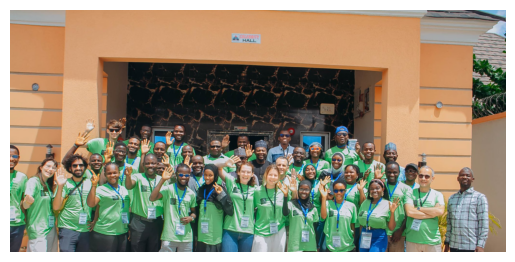

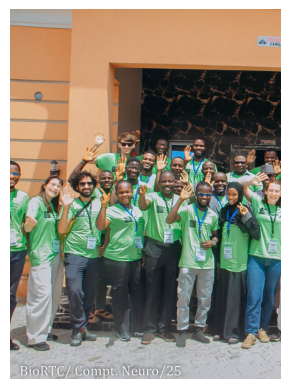

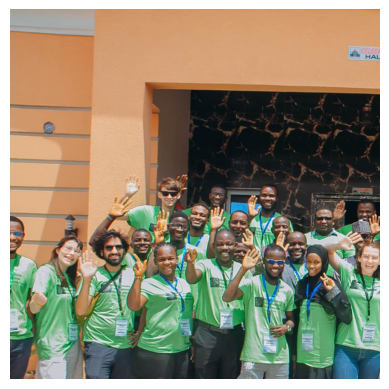

In [84]:
cropped_y=image[0:1000,:] #crop one way
cropped_x=image[:,0:1000] #crop one way
cropped_both=image[0:1000,0:1000]

plt.imshow(cropped_y)
plt.axis("off")
plt.show()

plt.imshow(cropped_x)
plt.axis("off")
plt.show()

plt.imshow(cropped_both)
plt.axis("off")
plt.show()

## Example classification task

In [61]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
from tqdm import tqdm
# Load the latest version
path = kagglehub.dataset_download("zlatan599/mushroom1")
print(path)
df = pd.read_csv(path+"/train.csv")
df

C:\Users\dexte\.cache\kagglehub\datasets\zlatan599\mushroom1\versions\1


image_path  \
0       /kaggle/working/merged_dataset/Lycoperdon perl...   
1       /kaggle/working/merged_dataset/Chlorociboria a...   
2       /kaggle/working/merged_dataset/Amanita muscari...   
3       /kaggle/working/merged_dataset/Xanthoria parie...   
4       /kaggle/working/merged_dataset/Coprinellus mic...   
...                                                   ...   
689515  /kaggle/working/merged_dataset/Vulpicida pinas...   
689516  /kaggle/working/merged_dataset/Vulpicida pinas...   
689517  /kaggle/working/merged_dataset/Vulpicida pinas...   
689518  /kaggle/working/merged_dataset/Vulpicida pinas...   
689519  /kaggle/working/merged_dataset/Vulpicida pinas...   

                              label  
0               Lycoperdon perlatum  
1       Chlorociboria aeruginascens  
2                  Amanita muscaria  
3               Xanthoria parietina  
4              Coprinellus micaceus  
...                             ...  
689515           Vulpicida pinastri  
689516           Vulpicida pinastri  
689517           Vulpicida pinastri  
689518           Vulpicida pinastri  
689519           Vulpicida pinastri  

[689520 rows x 2 columns]

### inspect the data
as we can see the data contains image paths

100%|██████████| 12240/12240 [00:28<00:00, 431.24it/s]

(12240, 64, 64, 3)


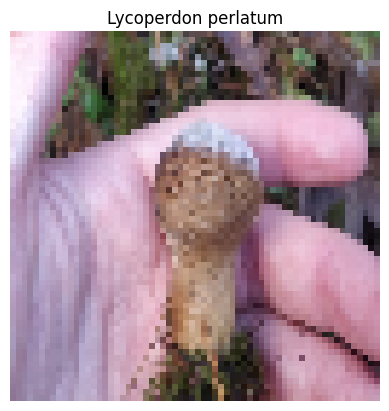

In [76]:
selected_classes = ['Lycoperdon perlatum', 'Chlorociboria aeruginascens', 'Amanita muscaria']

#filter the DataFrame
subset = df[df['label'].isin(selected_classes)]

target_size = (64, 64)  # adjust as needed

#load images into array
X = []
y = []

for _, row in tqdm(subset.iterrows(), total=len(subset)):
    img = cv2.imread(path+row['image_path'].replace("/kaggle/working",""))
    if img is None:
        continue  # skip broken paths
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X.append(img)
    y.append(selected_classes.index(row['label']))

X = np.array(X)
y = np.array(y)
print(X.shape)
plt.title(selected_classes[y[0]])
plt.imshow(X[0])
plt.axis("off")
plt.show()

### train a model with the dataset

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

#reshape the data so it is flat for each class
X_data=X.reshape(len(X),-1)
print(X_data.shape)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#split the data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

#train

rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)


(12240, 12288)


RandomForestClassifier(random_state=42)

In [88]:
#check
y_pred = rf.predict(X_test)

print("Accuracy on test data:", accuracy_score(y_test, y_pred)*100,"%")
print("Accuracy on train data:", accuracy_score(y_train, rf.predict(X_train))*100,"%")


Accuracy on test data: 98.17538126361656 %
Accuracy on train data: 100.0 %


### Augment
Play with the augmentation tchniques we mentioned above. You will need to write a function that loops through your dataset and applies the chosen function to all of it. Investigate which filters and parameters help with the data.

Firstly you can play around with cropping, image rotation ect... and see how well the model performs. Has it "learned" to recognise mushrooms no matter what direction they are in? Play around with noise, does it still classify. If so it means it is fairly robust as far as we can see. If not, maybe we need to train it with some noise to improve robustness.

If you get errors when combining the images, make sure the images are the same shape. If some are cropped and some arent, or some are RGB and some are filtered, it will not add together. If this happens you can convert the original dataset to greyscale 



In [ ]:
def apply_filter(X,y):
    new_dataset=[]
    for i in range(len(X)):
        current_image=X[i]
        processed = ... #TODO add process
        new_dataset.append(processed)  
    X1=np.array(new_dataset)
    return np.concatenate([X1,X]),np.concatenate([y,y])

new_x,new_y=apply_filter(...,...)

#shuffle the dataset
indices = np.arange(len(new_x))
np.random.shuffle(indices)
X_shuffled = new_x[indices]
y_shuffled = new_y[indices]

#use the shuffle values from here
print(X_shuffled.shape)

In [ ]:
#TODO apply a filter to the dataset
#TODO train a model on the augmented

### dimentionality reduction

Great, if you got here you have managed to play around with different augmentation tecqniques